In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.gridspec as gridspec

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()

print("Total records (before filtering):", len(sfrs))
print("Total records (after filtering AVG >= -80):", len(sfrs_filtered))
print("FLAG == 0 count:", len(sfrs_flag0_filtered))

mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

Total records (before filtering): 34613
Total records (after filtering AVG >= -80): 30752
FLAG == 0 count: 16841


In [4]:
all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]
cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)

Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)


In [6]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    return normalized_list

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


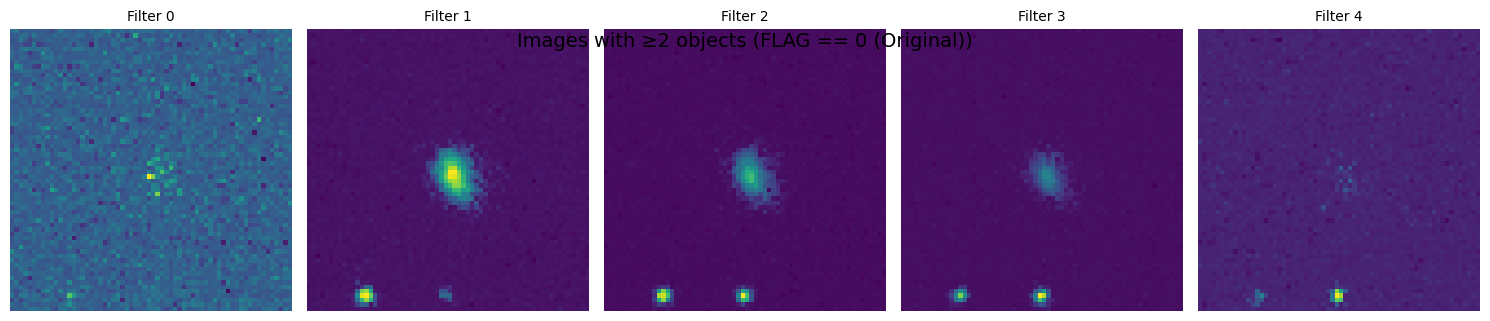

In [7]:
selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

CROP_SIZES_4 = {0: 32, 1: 16, 2: 8, 3: 4} 
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(
    normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None,
    group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra
)

In [8]:
X_photo_all = orig_images_flag0[0]        
X_spec_all = normalized_filtered_spectra[0]  
mask_good = np.ones(X_photo_all.shape[0], dtype=bool)
mask_good[multi_obj_indices_flag0] = False

X_photo = X_photo_all[mask_good]
X_spec = X_spec_all[mask_good]
Y = selected_Y_flag0[:X_photo_all.shape[0]][mask_good]

n_samples = min(X_photo.shape[0], X_spec.shape[0], len(Y))
X_photo = X_photo[:n_samples]
X_spec = X_spec[:n_samples]
Y = Y[:n_samples]

In [9]:
X_photo_train_val, X_photo_test, X_spec_train_val, X_spec_test, Y_train_val, Y_test = train_test_split(
    X_photo, X_spec, Y, test_size=0.2, random_state=42
)
X_photo_train, X_photo_val, X_spec_train, X_spec_val, Y_train, Y_val = train_test_split(
    X_photo_train_val, X_spec_train_val, Y_train_val, test_size=0.25, random_state=42
)

print("Train samples:", X_photo_train.shape[0])
print("Validation samples:", X_photo_val.shape[0])
print("Test samples:", X_photo_test.shape[0])

Train samples: 6040
Validation samples: 2014
Test samples: 2014


# Machine Learning (FLAG == 0 only):

## VGGNet12:

In [10]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    def forward(self, output, target):
        if target.dim() == 1:
            target = target.view(-1, 1)
        return F.mse_loss(output, target)

class VGGNet12(nn.Module):
    def __init__(self, input_channels, input_height, input_width, dropout=0.5):
        super(VGGNet12, self).__init__()
        if input_height == 1:
            pool1 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
            pool2 = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))
        else:
            pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool1
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            pool2
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        pool_h = max(1, input_height // 8)
        pool_w = max(1, input_width // 8)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        fc_input_dim = 256 * pool_h * pool_w
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [11]:
def plot_history(model, fusion_name):
    train_losses = [epoch['train_loss'] for epoch in model.history]
    valid_losses = [epoch['valid_loss'] for epoch in model.history]
    best_epoch = int(np.argmin(valid_losses))
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Selected Model (Epoch {best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{fusion_name} - Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def train_model(X_train, Y_train, X_val, Y_val, input_channels, input_height, input_width, lr, dropout, patience, fusion_name):
    net = NeuralNetRegressor(
        module=VGGNet12,
        module__input_channels=input_channels,
        module__input_height=input_height,
        module__input_width=input_width,
        module__dropout=dropout,
        max_epochs=50,
        lr=lr,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=patience))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    start = time.time()
    net.fit(X_train, Y_train)
    duration = time.time() - start
    Y_pred = net.predict(X_val)
    mae = mean_absolute_error(Y_val, Y_pred)
    r2_val = r2_score(Y_val, Y_pred)
    error = Y_pred - Y_val
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y_val, Y_pred))
    return net, mae, r2_val, nmad, rmse, duration

param_lr = [0.01, 0.001, 0.0001]
param_dropout = [0.5]
param_early = [10]

In [12]:
X_spec_train_cnn = X_spec_train.reshape(X_spec_train.shape[0], 1, 1, X_spec_train.shape[1])
X_spec_val_cnn = X_spec_val.reshape(X_spec_val.shape[0], 1, 1, X_spec_val.shape[1])
X_spec_test_cnn = X_spec_test.reshape(X_spec_test.shape[0], 1, 1, X_spec_test.shape[1])
input_channels_spec = 1
input_height_spec = 1
input_width_spec = X_spec_train.shape[1]

X_spec_train_4d = X_spec_train.reshape(X_spec_train.shape[0], 1, 1, X_spec_train.shape[1])
X_spec_val_4d = X_spec_val.reshape(X_spec_val.shape[0], 1, 1, X_spec_val.shape[1])
X_spec_test_4d = X_spec_test.reshape(X_spec_test.shape[0], 1, 1, X_spec_test.shape[1])
target_size_train = (X_photo_train.shape[2], X_photo_train.shape[3])
target_size_val = (X_photo_val.shape[2], X_photo_val.shape[3])
target_size_test = (X_photo_test.shape[2], X_photo_test.shape[3])
X_spec_train_tensor = torch.from_numpy(X_spec_train_4d).float()
X_spec_val_tensor = torch.from_numpy(X_spec_val_4d).float()
X_spec_test_tensor = torch.from_numpy(X_spec_test_4d).float()
X_spec_train_resized = F.interpolate(X_spec_train_tensor, size=target_size_train, mode='bilinear', align_corners=False).numpy()
X_spec_val_resized = F.interpolate(X_spec_val_tensor, size=target_size_val, mode='bilinear', align_corners=False).numpy()
X_spec_test_resized = F.interpolate(X_spec_test_tensor, size=target_size_test, mode='bilinear', align_corners=False).numpy()
X_early_train = np.concatenate([X_photo_train, X_spec_train_resized], axis=1)
X_early_val = np.concatenate([X_photo_val, X_spec_val_resized], axis=1)
X_early_test = np.concatenate([X_photo_test, X_spec_test_resized], axis=1)
input_channels_photo = X_photo_train.shape[1]
input_height_photo = X_photo_train.shape[2]
input_width_photo = X_photo_train.shape[3]
input_channels_early = X_early_train.shape[1]
input_height_early = X_early_train.shape[2]
input_width_early = X_early_train.shape[3]

runtime = {}

## Spectrum and Photo separately:

### VGGNet12 on Photo: 

Training VGGNet Photo Model
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  5304552.6255        0.5662  3.6612
      2    84188.9809        0.5663  2.5087
      3     1728.5287        0.5666  2.5179
      4      702.5967        0.5666  2.5192
      5      170.8488        0.5663  2.5200
      6        0.5685        0.5661  2.5223
      7        0.5683        0.5660  2.5247
      8        0.5681        0.5658  2.5222
      9        0.6382        0.5655  2.5227
     10        0.5677        0.5653  2.5201
     11        0.5675        0.5650  2.5223
     12        0.5672        0.5647  2.5247
     13        0.5669        0.5643  2.5251
     14        0.5666        0.5640  2.5204
     15        0.5662        0.5636  2.5198
     16       13.3947        0.5633  2.5223
     17        0.5656        0.5628  2.5218
     18        0.5652        0.5624  2.5236
     19        0.6748        0.5619  2.5248
     20        0.5642        0.5613  2.5228
    

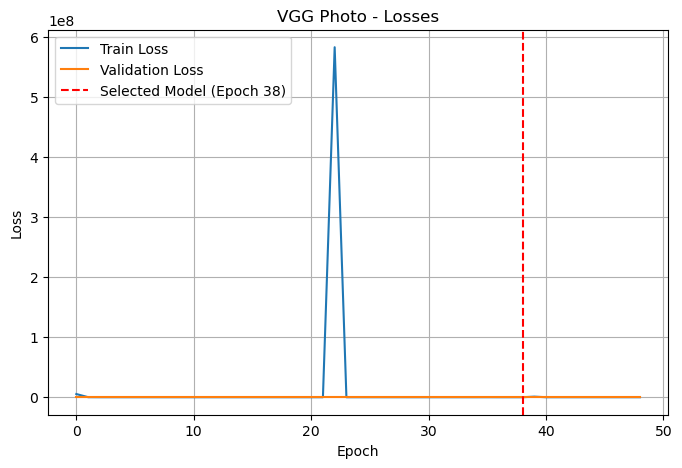

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5359        0.5257  2.5177
      2        0.5333        0.5264  2.5173
      3        0.5341        0.5247  2.5204
      4        0.5335        0.5257  2.5211
      5        0.5333        0.5251  2.5247
      6        0.5334        0.5247  2.5185
      7        0.5331        0.5259  2.5061
      8        0.5342        0.5247  2.5019
      9        0.5330        0.5258  2.5041
     10        0.5336        0.5246  2.5015
     11        0.5335        0.5245  2.5120
     12        0.5333        0.5246  2.5171
     13        0.5333        0.5246  2.5217
     14        0.5335        0.5247  2.5200
     15        0.5332        0.5245  2.5195
     16        0.5337        0.5245  2.5183
     17        0.5333        0.5247  2.5226
     18        0.5336        0.5248  2.5185
     19        0.5331        0.5248  2.5234
     20        0.5335        0.5247  2.5224
     21        0.5330        0.5

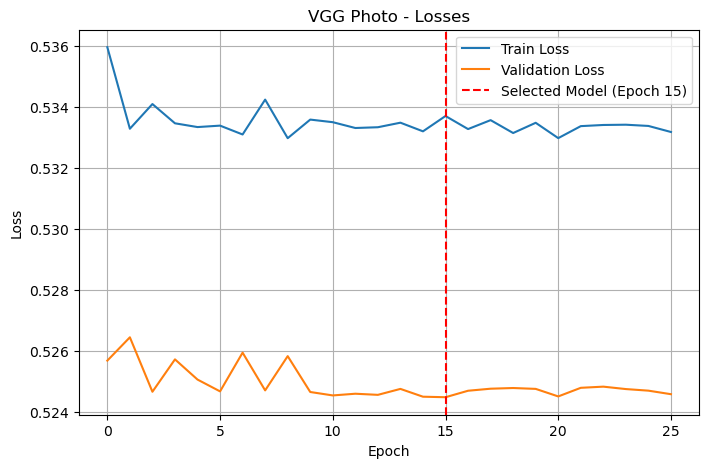

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5356        0.5241  2.5333
      2        0.5337        0.5236  2.5317
      3        0.5298        0.5133  2.5298
      4        0.5138        0.4943  2.5297
      5        0.5006        0.4797  2.5260
      6        0.4916        0.4679  2.5289
      7        0.4905        0.4747  2.5301
      8        0.4815        0.4663  2.5376
      9        0.4790        0.4812  2.5311
     10        0.4772        0.4638  2.5303
     11        0.4643        0.4459  2.5245
     12        0.4607        0.4429  2.5197
     13        0.4547        0.4314  2.5022
     14        0.4404        0.4126  2.5115
     15        0.4346        0.4184  2.5080
     16        0.4236        0.4356  2.5050
     17        0.4194        0.4295  2.5070
     18        0.4162        0.4050  2.5095
     19        0.4046        0.3922  2.5154
     20        0.4024        0.4046  2.5108
     21        0.3948        0.3

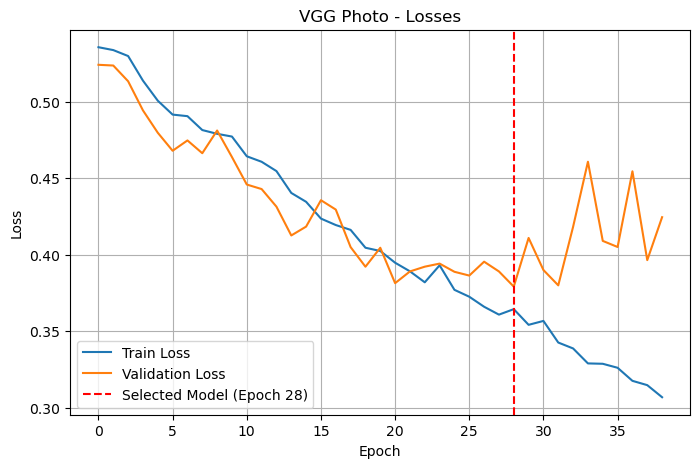

VGGNet Photo - Best Params: lr = 0.0001, dropout = 0.5, early_stop = 10, training time = 98.18 sec


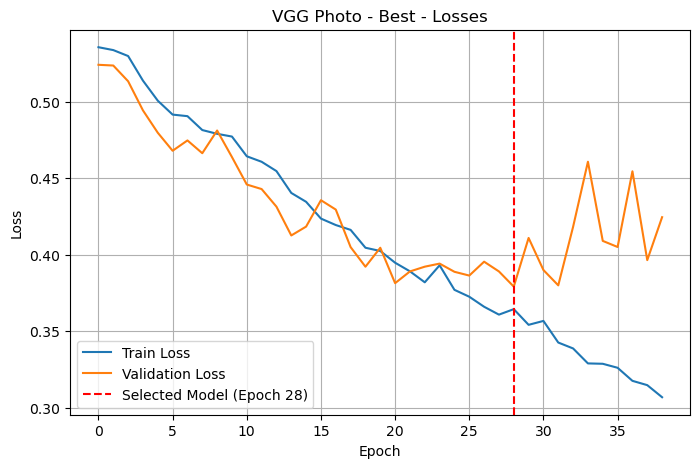

In [13]:
print("Training VGGNet Photo Model")
best_val = float('inf')
vgg_photo_model = None
best_params_photo = None
best_metrics_photo = None
best_runtime_photo = None
for lr in param_lr:
    for dropout in param_dropout:
        for early in param_early:
            net, mae, r2_val, nmad, rmse, duration = train_model(X_photo_train, Y_train, X_photo_val, Y_val,
                                                                  input_channels_photo, input_height_photo, input_width_photo,
                                                                  lr, dropout, early, "VGG Photo")
            print(f"VGG Photo - Params: lr = {lr}, dropout = {dropout}, early_stop = {early}, MAE = {mae:.4f}, r2 = {r2_val:.4f}, NMAD = {nmad:.4f}, RMSE = {rmse:.4f}, training time = {duration:.2f} sec")
            plot_history(net, "VGG Photo")
            if mae < best_val:
                best_val = mae
                vgg_photo_model = net
                best_params_photo = (lr, dropout, early)
                best_metrics_photo = (mae, r2_val, nmad, rmse)
                best_runtime_photo = duration
print(f"VGGNet Photo - Best Params: lr = {best_params_photo[0]}, dropout = {best_params_photo[1]}, early_stop = {best_params_photo[2]}, training time = {best_runtime_photo:.2f} sec")
plot_history(vgg_photo_model, "VGG Photo - Best")
vgg_photo_model.save_params(f_params="vgg_photo_model.pt")
runtime["VGGNet Photo"] = best_runtime_photo

### VGGNet12 on Spectra:

Training VGGNet Spectra Model
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1     8840.2038        0.5265  15.6505
      2        0.5402        0.5252  15.6434
      3        0.5403        0.5266  15.6523
      4        0.5424        0.5268  15.6647
      5        0.5389        0.5255  15.6577
      6        0.5416        0.5263  15.6637
      7        0.5394        0.5266  15.6691
      8        0.5385        0.5252  15.6733
      9        0.5409        0.5259  15.6653
     10        0.5414        0.5263  15.6627
     11        0.5371        0.5246  15.6637
     12        0.5366        0.5259  15.6611
     13        0.5390        0.5263  15.6722
     14        0.5393        0.5251  15.6713
     15        0.5392        0.5254  15.6746
     16        0.5386        0.5292  15.6683
     17        0.5383        0.5252  15.6678
     18        0.5373        0.5247  15.6682
     19        0.5383        0.5250  15.6671
     20        0.5383    

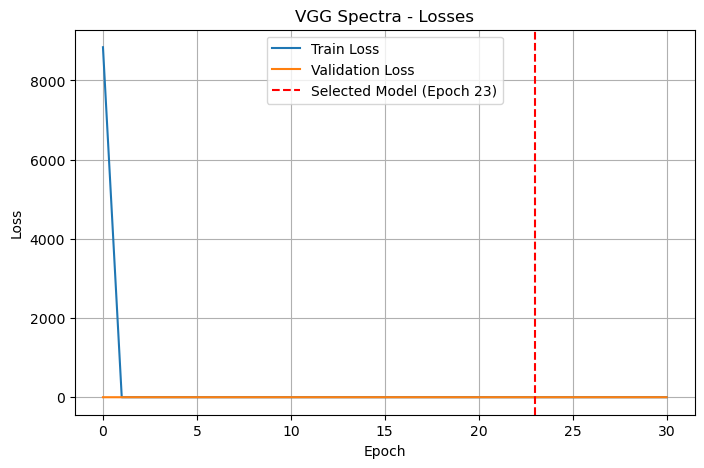

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5389        0.5245  15.7498
      2        0.5346        0.5252  15.7287
      3        0.5330        0.5245  15.7219
      4        0.5339        0.5245  15.7198
      5        0.5339        0.5248  15.7234
      6        0.5345        0.5248  15.7227
      7        0.5328        0.5244  15.7295
      8        0.5336        0.5247  15.7283
      9        0.5337        0.5249  15.7319
     10        0.5334        0.5245  15.7306
     11        0.5331        0.5245  15.7273
     12        0.5334        0.5257  15.7275
Stopping since valid_loss has not improved in the last 10 epochs.
VGG Spectra - Params: lr = 0.001, dropout = 0.5, early_stop = 10, MAE = 0.6263, r2 = -0.0002, NMAD = 0.8640, RMSE = 0.7456, training time = 205.01 sec


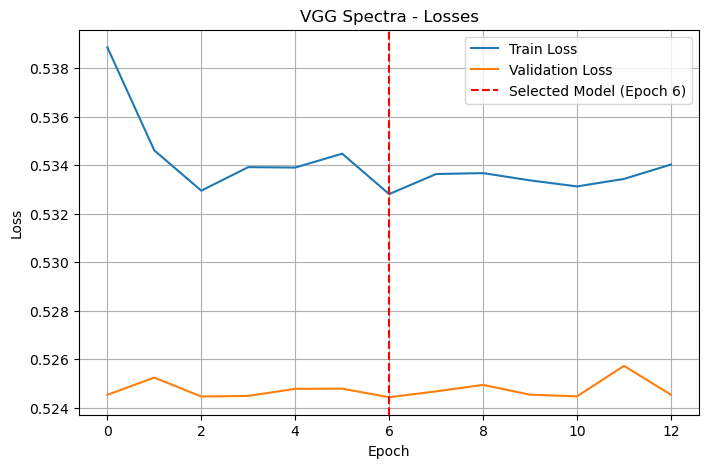

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.5346        0.5247  15.8713
      2        0.5340        0.5261  15.8656
      3        0.5315        0.5210  15.8631
      4        0.5296        0.5198  15.8529
      5        0.5279        0.5151  15.8551
      6        0.5268        0.5135  15.8507
      7        0.5252        0.5143  15.8542
      8        0.5256        0.5127  15.8520
      9        0.5250        0.5087  15.8466
     10        0.5257        0.5092  15.8380
     11        0.5225        0.5082  15.8303
     12        0.5231        0.5090  15.8262
     13        0.5229        0.5088  15.8228
     14        0.5194        0.5066  15.8315
     15        0.5221        0.5083  15.8255
     16        0.5198        0.5101  15.8212
     17        0.5211        0.5050  15.8242
     18        0.5202        0.5082  15.8193
     19        0.5222        0.5115  15.8206
     20        0.5191        0.5061  15.8204
     21   

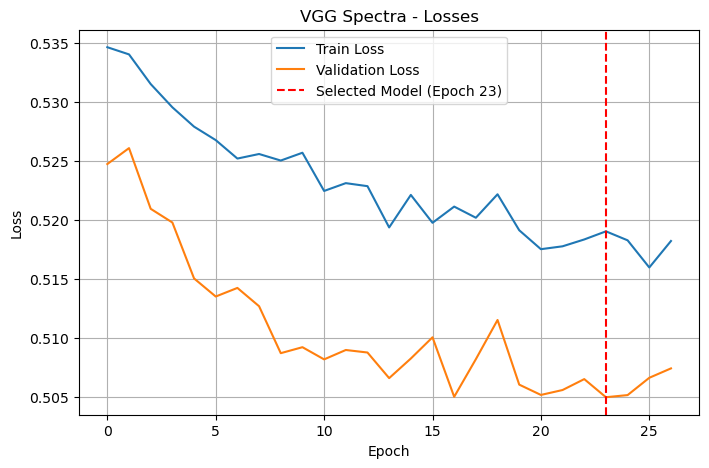

VGGNet Spectra - Best Params: lr = 0.0001, dropout = 0.5, early_stop = 10, training time = 428.08 sec


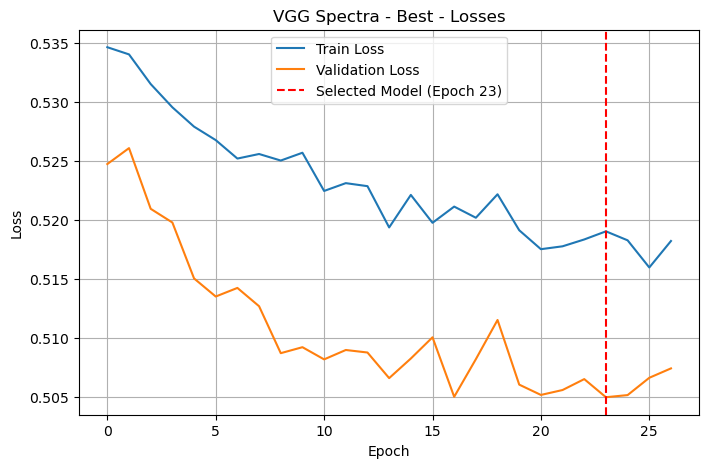

In [14]:
print("Training VGGNet Spectra Model")
best_val = float('inf')
vgg_spec_model = None
best_params_spec = None
best_metrics_spec = None
best_runtime_spec = None
for lr in param_lr:
    for dropout in param_dropout:
        for early in param_early:
            net, mae, r2_val, nmad, rmse, duration = train_model(X_spec_train_cnn, Y_train, X_spec_val_cnn, Y_val,
                                                                  input_channels_spec, input_height_spec, input_width_spec,
                                                                  lr, dropout, early, "VGG Spectra")
            print(f"VGG Spectra - Params: lr = {lr}, dropout = {dropout}, early_stop = {early}, MAE = {mae:.4f}, r2 = {r2_val:.4f}, NMAD = {nmad:.4f}, RMSE = {rmse:.4f}, training time = {duration:.2f} sec")
            plot_history(net, "VGG Spectra")
            if mae < best_val:
                best_val = mae
                vgg_spec_model = net
                best_params_spec = (lr, dropout, early)
                best_metrics_spec = (mae, r2_val, nmad, rmse)
                best_runtime_spec = duration
print(f"VGGNet Spectra - Best Params: lr = {best_params_spec[0]}, dropout = {best_params_spec[1]}, early_stop = {best_params_spec[2]}, training time = {best_runtime_spec:.2f} sec")
plot_history(vgg_spec_model, "VGG Spectra - Best")
vgg_spec_model.save_params(f_params="vgg_spec_model.pt")
runtime["VGGNet Spectra"] = best_runtime_spec

### VGGNet12 Early Fusion:

Training VGGNet Early Fusion Model
  epoch     train_loss    valid_loss     dur
-------  -------------  ------------  ------
      1  22173889.6797        0.5562  2.5619
      2        1.6029        0.5561  2.5536
      3        1.5917        0.5561  2.5586
      4        0.5709        0.5561  2.5616
      5        0.5601        0.5560  2.5588
      6        0.5631        0.5560  2.5590
      7        0.5597        0.5559  2.5591
      8        0.5599        0.5558  2.5611
      9        0.5658        0.5557  2.5612
     10        0.5630        0.5557  2.5619
     11        0.5587        0.5556  2.5589
     12        0.5589        0.5554  2.5659
     13        0.5598        0.5553  2.5609
     14        0.5580        0.5552  2.5613
     15        0.5595        0.5551  2.5455
     16        0.5582        0.5549  2.5691
     17        0.5581        0.5548  2.5712
     18        0.5579        0.5546  2.5644
     19        0.5577        0.5544  2.5636
     20        0.5576        0.5542  2

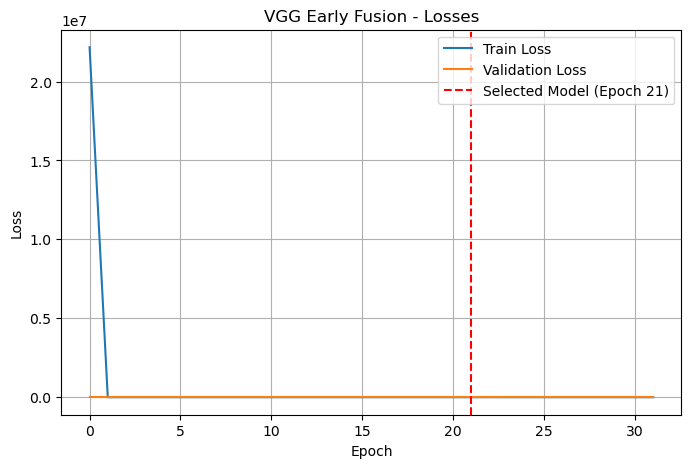

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5525        0.5252  2.5732
      2        0.5387        0.5248  2.5590
      3        0.5376        0.5259  2.5562
      4        0.5365        0.5245  2.5564
      5        0.5358        0.5245  2.5565
      6        0.5343        0.5248  2.5589
      7        0.5342        0.5244  2.5510
      8        0.5335        0.5254  2.5454
      9        0.5345        0.5260  2.5437
     10        0.5331        0.5248  2.5448
     11        0.5343        0.5251  2.5444
     12        0.5344        0.5246  2.5461
     13        0.5342        0.5244  2.5490
Stopping since valid_loss has not improved in the last 10 epochs.
VGG Early Fusion - Params: lr = 0.001, dropout = 0.5, early_stop = 10, MAE = 0.6265, r2 = -0.0004, NMAD = 0.8640, RMSE = 0.7457, training time = 35.82 sec


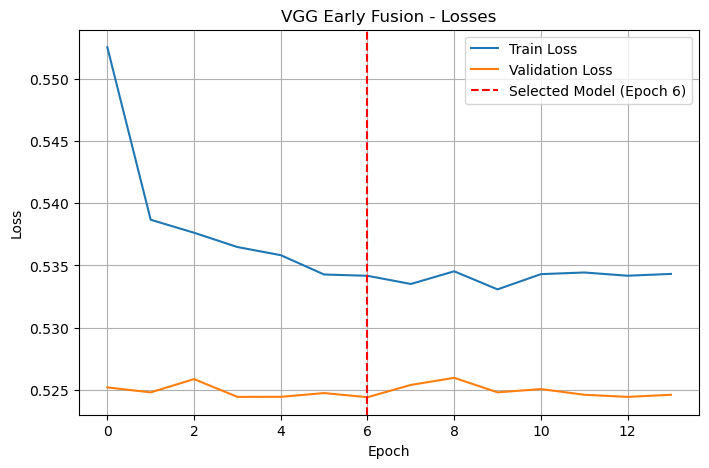

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5388        0.5283  2.5449
      2        0.5360        0.5211  2.5442
      3        0.5158        0.4897  2.5439
      4        0.5044        0.4840  2.5472
      5        0.5009        0.4726  2.5437
      6        0.4905        0.4747  2.5472
      7        0.4839        0.4702  2.5477
      8        0.4869        0.4682  2.5447
      9        0.4787        0.4637  2.5573
     10        0.4804        0.4653  2.5624
     11        0.4776        0.4614  2.5648
     12        0.4692        0.4609  2.5659
     13        0.4735        0.4562  2.5635
     14        0.4678        0.4656  2.5668
     15        0.4670        0.4559  2.5634
     16        0.4574        0.4542  2.5690
     17        0.4570        0.4398  2.5661
     18        0.4534        0.4492  2.5625
     19        0.4505        0.4377  2.5647
     20        0.4599        0.4422  2.5622
     21        0.4405        0.4

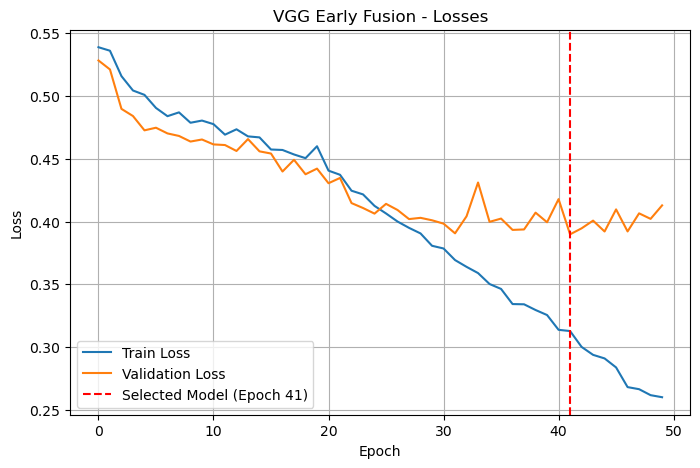

VGGNet Early Fusion - Best Params: lr = 0.0001, dropout = 0.5, early_stop = 10, training time = 128.26 sec


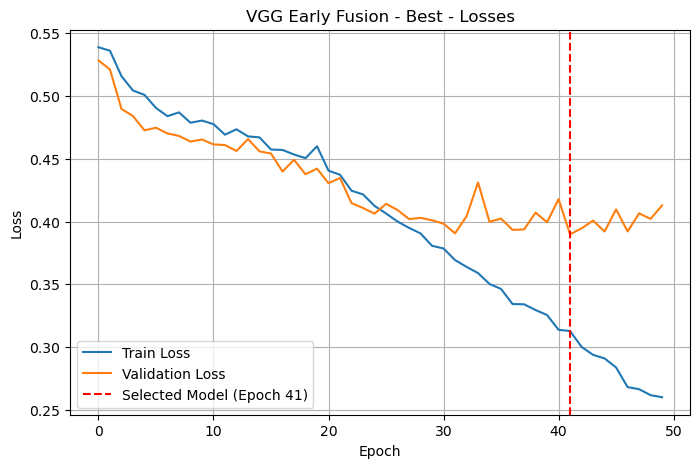

In [15]:
print("Training VGGNet Early Fusion Model")
best_val = float('inf')
vgg_early_model = None
best_params_early = None
best_metrics_early = None
best_runtime_early = None
for lr in param_lr:
    for dropout in param_dropout:
        for early in param_early:
            net, mae, r2_val, nmad, rmse, duration = train_model(X_early_train, Y_train, X_early_val, Y_val,
                                                                  input_channels_early, input_height_early, input_width_early,
                                                                  lr, dropout, early, "VGG Early Fusion")
            print(f"VGG Early Fusion - Params: lr = {lr}, dropout = {dropout}, early_stop = {early}, MAE = {mae:.4f}, r2 = {r2_val:.4f}, NMAD = {nmad:.4f}, RMSE = {rmse:.4f}, training time = {duration:.2f} sec")
            plot_history(net, "VGG Early Fusion")
            if mae < best_val:
                best_val = mae
                vgg_early_model = net
                best_params_early = (lr, dropout, early)
                best_metrics_early = (mae, r2_val, nmad, rmse)
                best_runtime_early = duration
print(f"VGGNet Early Fusion - Best Params: lr = {best_params_early[0]}, dropout = {best_params_early[1]}, early_stop = {best_params_early[2]}, training time = {best_runtime_early:.2f} sec")
plot_history(vgg_early_model, "VGG Early Fusion - Best")
vgg_early_model.save_params(f_params="vgg_early_model.pt")
runtime["VGGNet Early Fusion"] = best_runtime_early


### VGGNet12 Late Fusion:

In [16]:
Y_pred_vgg_photo_test = vgg_photo_model.predict(X_photo_test)
Y_pred_vgg_spec_test = vgg_spec_model.predict(X_spec_test_cnn)
Y_pred_vgg_late_test = (Y_pred_vgg_photo_test + Y_pred_vgg_spec_test) / 2.0
Y_pred_vgg_early_test = vgg_early_model.predict(X_early_test)
runtime["VGGNet Late Fusion"] = runtime["VGGNet Spectra"] + runtime["VGGNet Photo"]

### Compile all results:

In [17]:
def calc_metrics(Y_true, Y_pred):
    mae = mean_absolute_error(Y_true, Y_pred)
    r2 = r2_score(Y_true, Y_pred)
    error = Y_pred - Y_true
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    return mae, r2, nmad, rmse

vgg_photo_mae_test, vgg_photo_r2_test, vgg_photo_nmad_test, vgg_photo_rmse_test = calc_metrics(Y_test, Y_pred_vgg_photo_test)
vgg_spec_mae_test, vgg_spec_r2_test, vgg_spec_nmad_test, vgg_spec_rmse_test = calc_metrics(Y_test, Y_pred_vgg_spec_test)
vgg_early_mae_test, vgg_early_r2_test, vgg_early_nmad_test, vgg_early_rmse_test = calc_metrics(Y_test, Y_pred_vgg_early_test)
vgg_late_mae_test, vgg_late_r2_test, vgg_late_nmad_test, vgg_late_rmse_test = calc_metrics(Y_test, Y_pred_vgg_late_test)

comparison = {
    "VGGNet Photo": {
        'r2': vgg_photo_r2_test,
        'mae': vgg_photo_mae_test,
        'nmad': vgg_photo_nmad_test,
        'rmse': vgg_photo_rmse_test
    },
    "VGGNet Spectra": {
        'r2': vgg_spec_r2_test,
        'mae': vgg_spec_mae_test,
        'nmad': vgg_spec_nmad_test,
        'rmse': vgg_spec_rmse_test
    },
    "VGGNet Early Fusion": {
        'r2': vgg_early_r2_test,
        'mae': vgg_early_mae_test,
        'nmad': vgg_early_nmad_test,
        'rmse': vgg_early_rmse_test
    },
    "VGGNet Late Fusion": {
        'r2': vgg_late_r2_test,
        'mae': vgg_late_mae_test,
        'nmad': vgg_late_nmad_test,
        'rmse': vgg_late_rmse_test
    }
}

print("\nTest Metrics:")
for method, met in comparison.items():
    print(f"{method}: R² = {met['r2']:.3f}, MAE = {met['mae']:.3f}, NMAD = {met['nmad']:.3f}, RMSE = {met['rmse']:.3f}")


Test Metrics:
VGGNet Photo: R² = 0.195, MAE = 0.500, NMAD = 0.887, RMSE = 0.646
VGGNet Spectra: R² = 0.027, MAE = 0.590, NMAD = 0.832, RMSE = 0.710
VGGNet Early Fusion: R² = 0.214, MAE = 0.487, NMAD = 0.900, RMSE = 0.639
VGGNet Late Fusion: R² = 0.196, MAE = 0.521, NMAD = 0.833, RMSE = 0.646


### Visualization of comparative metrics:

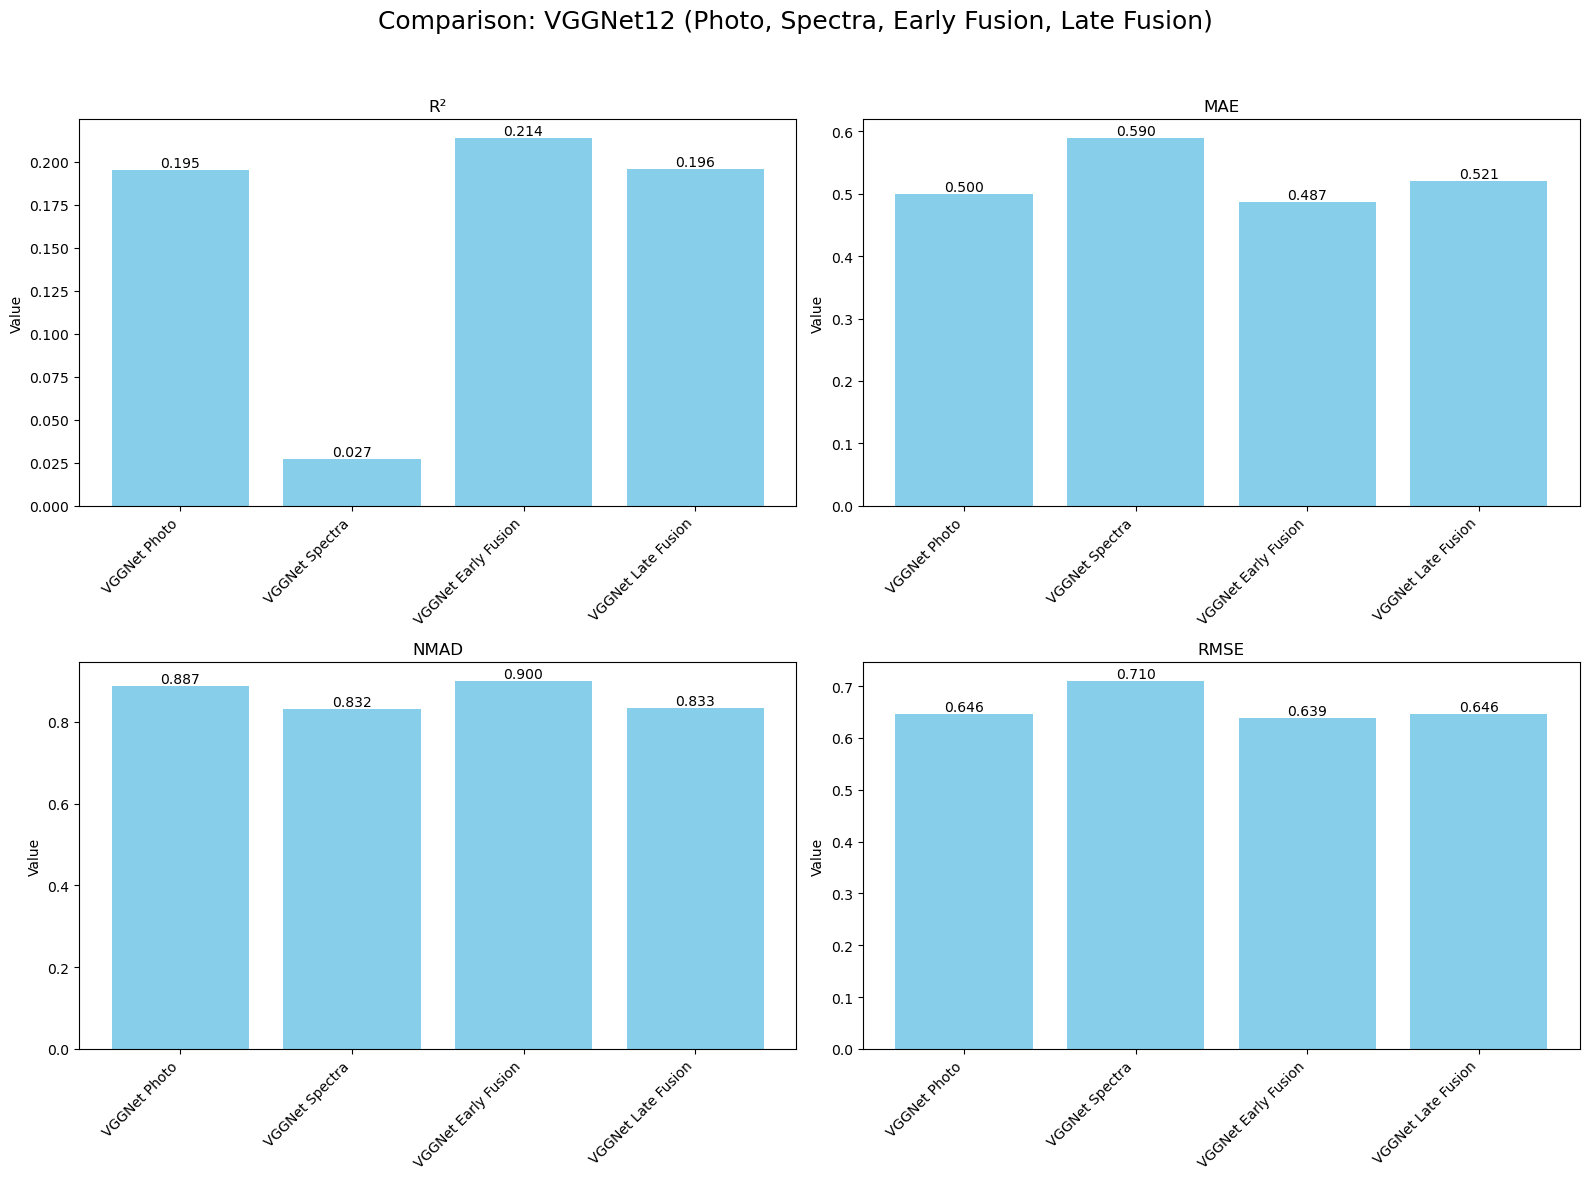

In [18]:
methods = list(comparison.keys())
metrics_names = ['R²', 'MAE', 'NMAD', 'RMSE']
values = {metric: [] for metric in metrics_names}
for method in methods:
    values['R²'].append(comparison[method]['r2'])
    values['MAE'].append(comparison[method]['mae'])
    values['NMAD'].append(comparison[method]['nmad'])
    values['RMSE'].append(comparison[method]['rmse'])
x = np.arange(len(methods))
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()
for i, metric in enumerate(metrics_names):
    axs[i].bar(x, values[metric], color='skyblue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(methods, rotation=45, ha='right')
    axs[i].set_title(metric)
    axs[i].set_ylabel("Value")
    for j, v in enumerate(values[metric]):
        axs[i].text(j, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.suptitle("Comparison: VGGNet12 (Photo, Spectra, Early Fusion, Late Fusion)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Visualization of runtimes:

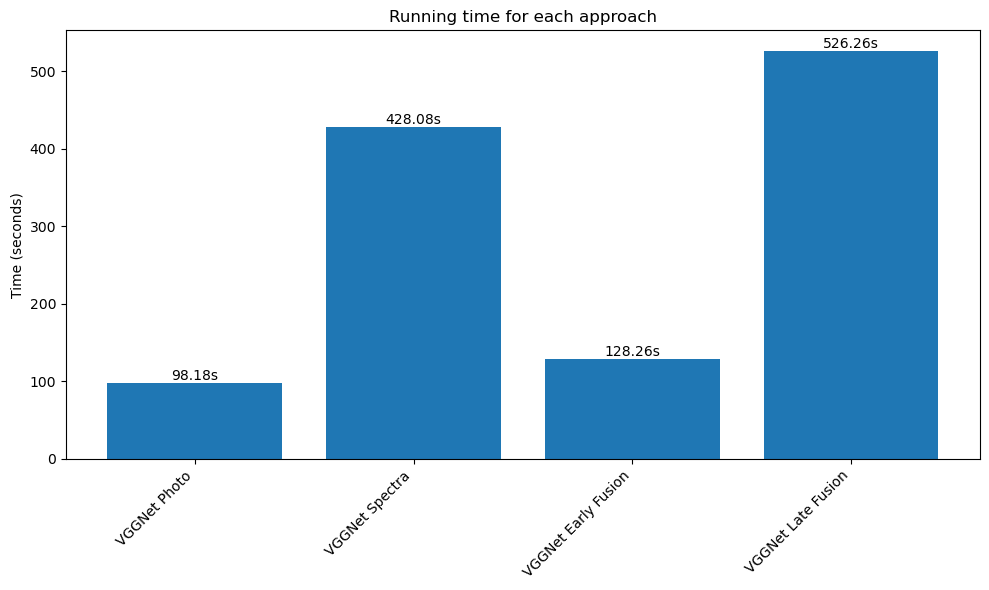

In [19]:
runtime_methods = list(runtime.keys())
runtime_values = [runtime[m] for m in runtime_methods]
plt.figure(figsize=(10, 6))
plt.bar(runtime_methods, runtime_values)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Time (seconds)")
plt.title("Running time for each approach")
for i, t in enumerate(runtime_values):
    plt.text(i, t, f"{t:.2f}s", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()